In [35]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import pandas as pd

## 1. Load the Best Probe Weights

In [29]:
# Path to your results
# MODEL_NAME = "Qwen/Qwen2.5-Math-7B-Instruct"
# MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B-Instruct"
MODEL_ALIAS = "-".join(MODEL_NAME.split("/"))
RESULTS_DIR = f"../probe_results/DATA/SR_DATA/MATH/{MODEL_ALIAS}_maxlen_3000_k_5_temp_1.0"

# Load best probe data
with open(f"{RESULTS_DIR}/best_probe_predictions.json", 'r') as f:
    best_probe = json.load(f)

probe_weights = np.array(best_probe['probe_weights'])  # [D] dimension vector
best_layer = best_probe['best_layer']
best_position = best_probe['best_position']
cv_score = best_probe['cv_score']
test_score = best_probe['test_score']

print(f"Best probe: Layer {best_layer}, Position {best_position}")
print(f"CV Score: {cv_score:.4f}, Test Score: {test_score:.4f}")
print(f"Probe weights shape: {probe_weights.shape}")

Best probe: Layer 18, Position -1
CV Score: 0.6900, Test Score: 0.6961
Probe weights shape: (1537,)


## 2. Load Model and Extract Embedding Matrix

In [30]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
vocab_size = len(tokenizer)
print(f"Vocabulary size: {vocab_size}")

# Load model to get embeddings
print("Loading model (this may take a moment)...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="cpu",  # Keep on CPU for analysis
)

# Get embedding matrix
embedding_matrix = model.get_input_embeddings().weight.data.cpu().float().numpy()  # [vocab_size, d_model]
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Vocabulary size: 151665
Loading model (this may take a moment)...
Embedding matrix shape: (151936, 1536)
Embedding matrix shape: (151936, 1536)


## 3. Compute Dot Products with All Tokens

In [31]:
# Compute dot product: embedding_matrix @ probe_weights
# This tells us how much each token "activates" the probe direction
dot_products = embedding_matrix @ probe_weights  # [vocab_size]

print(f"Dot products shape: {dot_products.shape}")
print(f"Min: {dot_products.min():.4f}, Max: {dot_products.max():.4f}, Mean: {dot_products.mean():.4f}")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1537 is different from 1536)

## 4. Find Top Tokens (Highest Activations)

In [24]:
# Get top K tokens with highest dot products
TOP_K = 50

top_indices = np.argsort(dot_products)[-TOP_K:][::-1]  # Descending order
top_scores = dot_products[top_indices]
top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

# Create DataFrame
top_df = pd.DataFrame({
    'rank': range(1, TOP_K + 1),
    'token_id': top_indices,
    'token': top_tokens,
    'dot_product': top_scores,
})

print(f"\n{'='*60}")
print(f"TOP {TOP_K} TOKENS (Highest Activation)")
print(f"{'='*60}\n")
print(top_df.to_string(index=False))


TOP 50 TOKENS (Highest Activation)

 rank  token_id       token  dot_product
    1      2073           “     0.054637
    2      5435     related     0.052639
    3     15670         .',     0.049538
    4      8296        hash     0.048453
    5        90           {     0.048061
    6     14835           „     0.047018
    7     34883      correl     0.046101
    8     28369        Diff     0.046055
    9      5059         ara     0.045197
   10     84386          {s     0.044995
   11     41156       annes     0.044963
   12     25838   boyfriend     0.044765
   13    103918           〔     0.044468
   14     53692          `{     0.044130
   15     18469          .:     0.043583
   16    113317          较差     0.043223
   17     81556          `(     0.042979
   18     26891        keen     0.042919
   19     40381    Examples     0.042261
   20     50378         -fr     0.042092
   21      9388          /{     0.042041
   22      4960       extra     0.041958
   23      1986     

## 5. Find Bottom Tokens (Lowest Activations)

In [25]:
# Get bottom K tokens (most negative)
bottom_indices = np.argsort(dot_products)[:TOP_K]
bottom_scores = dot_products[bottom_indices]
bottom_tokens = [tokenizer.decode([idx]) for idx in bottom_indices]

bottom_df = pd.DataFrame({
    'rank': range(1, TOP_K + 1),
    'token_id': bottom_indices,
    'token': bottom_tokens,
    'dot_product': bottom_scores,
})

print(f"\n{'='*60}")
print(f"BOTTOM {TOP_K} TOKENS (Lowest Activation)")
print(f"{'='*60}\n")
print(bottom_df.to_string(index=False))


BOTTOM 50 TOKENS (Lowest Activation)

 rank  token_id        token  dot_product
    1     99314            走    -0.053488
    2      2020         come    -0.050309
    3     41070     Academic    -0.049565
    4     18495    computers    -0.047449
    5     38095     Benefits    -0.046878
    6     54970        stral    -0.045322
    7     25420         unto    -0.045086
    8    101158          是一种    -0.044016
    9     36765     Hardware    -0.043919
   10     57154            �    -0.043758
   11     60279        ность    -0.043086
   12     45880     dividend    -0.041993
   13      7306        inton    -0.041922
   14     58250       anteed    -0.041881
   15    110314           电磁    -0.041734
   16     16408      Country    -0.041677
   17     54927     utorials    -0.041417
   18     12835      gricult    -0.041088
   19     17482          Buy    -0.040992
   20    124326          الك    -0.040955
   21     20967      allowed    -0.040800
   22     15249         ções    -0.04

## 6. Visualize Distribution

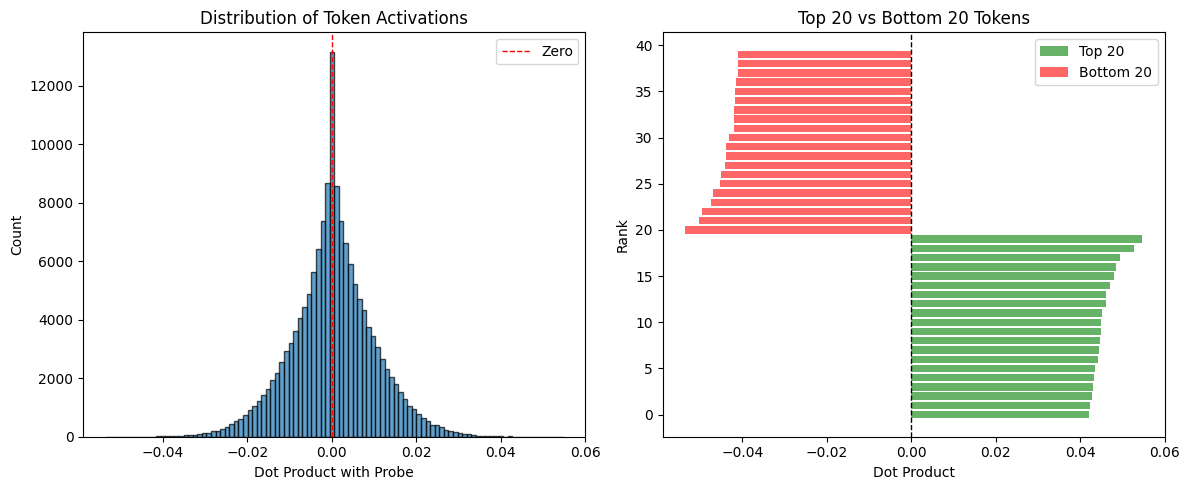

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(dot_products, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Dot Product with Probe')
plt.ylabel('Count')
plt.title('Distribution of Token Activations')
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')
plt.legend()

# Top/Bottom bars
plt.subplot(1, 2, 2)
plt.barh(range(20), top_scores[:20][::-1], color='green', alpha=0.6, label='Top 20')
plt.barh(range(20, 40), bottom_scores[:20], color='red', alpha=0.6, label='Bottom 20')
plt.xlabel('Dot Product')
plt.ylabel('Rank')
plt.title('Top 20 vs Bottom 20 Tokens')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend()

plt.tight_layout()
plt.show()

## 7. Save Results

In [27]:
# Save to CSV
top_df.to_csv(f"{RESULTS_DIR}/top_tokens.csv", index=False)
bottom_df.to_csv(f"{RESULTS_DIR}/bottom_tokens.csv", index=False)

print(f"\nResults saved to:")
print(f"  - {RESULTS_DIR}/top_tokens.csv")
print(f"  - {RESULTS_DIR}/bottom_tokens.csv")


Results saved to:
  - ../probe_results/DATA/SR_DATA/MATH/Qwen-Qwen2.5-Math-7B-Instruct_maxlen_3000_k_1_temp_0.0/top_tokens.csv
  - ../probe_results/DATA/SR_DATA/MATH/Qwen-Qwen2.5-Math-7B-Instruct_maxlen_3000_k_1_temp_0.0/bottom_tokens.csv


## 8. Interpretation

- **High dot product tokens**: These tokens, when they appear at the probe's position/layer, strongly activate in the direction the probe learned to associate with high success rate.
- **Low dot product tokens**: These tokens activate in the opposite direction

**Note**: This analysis uses the embedding matrix, so it shows tokens at the input level. The actual activations the probe sees are after being processed through layers of the transformer, so this is an approximation of what the probe detects.